In [1]:
!pip install heartpy

In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import random
import numpy as np
import matplotlib.pyplot as plt


from keras import layers, Sequential
from keras.layers import Input, Add, Dense, Activation, ZeroPadding1D, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout
from keras.models import Model
from keras.preprocessing.sequence import pad_sequences


import pandas as pd
from scipy.signal import butter, lfilter
from scipy import stats
from scipy.io import loadmat

import heartpy as hp

from sklearn.preprocessing import MaxAbsScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import seaborn as sns


import math
import random
import zipfile  
import io
from PIL import Image

In [3]:
SEED = 4224
tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [4]:
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/FinalAssignment'
os.chdir(cwd)
dataset_folder = os.path.join(cwd,'training_set_dir')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
def load_data(sample_prefix, input_dir):    # everything is returned as a numpy array which is easier to manipulate
  label_filepath = os.path.join(input_dir, sample_prefix + '_ann.mat')
  peak_filepath = os.path.join(input_dir, sample_prefix + '_rpk.mat')
  signal_filepath = os.path.join(input_dir, sample_prefix + '.mat')
  if os.path.isfile(label_filepath):
    mat_file = loadmat(label_filepath)
    label = np.asarray(mat_file['labels'])
  if os.path.isfile(peak_filepath):
    mat_file = loadmat(peak_filepath)
    peak = np.asarray(mat_file['rpeaks'])
  if os.path.isfile(signal_filepath):
    mat_file = loadmat(signal_filepath)
    signal = np.asarray(mat_file['ecg'] )

  return label, peak, signal

  
labels = list()             # labels 
ids = list()                # Id of samples 
rpeaks = list()             # detected peaks of the signal 
ecg_signals = list()        # .mat ecg signal 
frequencies = list()        # sample frequency of the ecg signal 


for f in os.listdir(dataset_folder):
  if f.lower().endswith('.mat'):
    id = f[:4]
    if id not in ids:
      ids.append(id)
      sample_prefix = f[:8]
      label, peak, signal = load_data(sample_prefix, dataset_folder)
      labels.append(label)
      rpeaks.append(peak)
      ecg_signals.append(signal)
      frequencies.append(int(sample_prefix[5:]))

print(len(rpeaks))
print(len(rpeaks[0]))

105
2335


In [6]:
cols = ["sigId","ecg_lead_1","ecg_lead_2","peaks","frequencies","labels"]

# ecg signals is 105 rows [,,,,,]

first_lead_signals = []
second_lead_signals = []

for signal in ecg_signals:
    first_lead_signals.append(signal[:,0].tolist())    # converting the array to list as list of array is deprecated 
    second_lead_signals.append(signal[:,1].tolist())

df = pd.DataFrame(data =[ids,first_lead_signals,second_lead_signals,rpeaks,frequencies,labels]).T
df.columns = cols
df

,sigId,ecg_lead_1,ecg_lead_2,peaks,frequencies,labels
0,S002,"[-0.035, -0.045, -0.025, -0.035, -0.045, -0.05...","[-0.095, -0.105, -0.095, -0.095, -0.115, -0.09...","[[48], [153], [243], [352], [440], [547], [636...",128,"[N, N, N, N, S, N, S, N, S, N, S, N, S, N, S, ..."
1,S001,"[0.0, 0.04, 0.03, 0.0, 0.03, 0.09, 0.18, 0.14,...","[0.08, 0.07, 0.1, 0.06, 0.06, 0.03, 0.1, 0.21,...","[[29], [110], [191], [272], [353], [433], [514...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
2,S004,"[-0.46, -0.49, -0.52, -0.58, -0.62, -0.69, -0....","[0.56, 0.61, 0.66, 0.66, 0.63, 0.66, 0.59, 0.5...","[[98], [223], [349], [474], [599], [726], [853...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
3,S003,"[-0.56, -0.56, -0.55, -0.47, -0.53, -0.47, -0....","[0.43, 0.56, 0.6, 0.41, 0.54, 0.48, 0.56, 0.46...","[[91], [209], [326], [394], [537], [653], [745...",128,"[N, N, N, S, N, N, S, N, N, S, N, N, N, N, N, ..."
4,S005,"[-0.27, -0.17, -0.13, -0.23, -0.18, -0.23, -0....","[-0.02, -0.04, -0.01, -0.01, -0.02, -0.06, 0.0...","[[27], [127], [225], [324], [423], [523], [623...",128,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
...,...,...,...,...,...,...
100,S114,"[-0.22, -0.225, -0.23, -0.22, -0.185, -0.155, ...","[-0.86, -0.905, -0.94, -0.975, -1.0, -1.025, -...","[[155], [383], [611], [835], [1053], [1275], [...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
101,S115,"[0.385, 0.35, 0.31, 0.285, 0.265, 0.25, 0.225,...","[0.515, 0.45, 0.38, 0.33, 0.3, 0.28, 0.25, 0.2...","[[215], [437], [667], [823], [1119], [1349], [...",250,"[N, N, N, V, N, N, N, V, N, N, N, N, N, N, N, ..."
102,S116,"[-0.12, -0.12, -0.12, -0.125, -0.12, -0.115, -...","[-0.1, -0.105, -0.11, -0.125, -0.135, -0.13, -...","[[255], [535], [817], [1093], [1377], [1657], ...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."
103,S117,"[-0.045, -0.045, -0.045, -0.045, -0.045, -0.04...","[0.175, 0.185, 0.18, 0.175, 0.175, 0.175, 0.17...","[[19], [295], [575], [863], [1151], [1435], [1...",250,"[N, N, N, N, N, N, N, N, N, N, N, N, N, N, N, ..."


In [7]:
# dataset needs to be created because we need to classify beats and not the entire signal 

classes = np.array(["N","S","V"])

def convert_to_one_hot(label):
    return np.array(classes == label,dtype=np.float32)


dataset = dict()
length = 510    # length of each signal, centered at the considered peak
counter = 0


for l,id in enumerate(ids):
    print(f"{l}/{len(ids)}",end='\r')
    for i,peak in enumerate(rpeaks[l]):
        
        dataset[id+"_"+str(i)] = {}
        dataset[id+"_"+str(i)]["first_lead"] = list()
        dataset[id+"_"+str(i)]["second_lead"] = list()

        for s in range(int(peak-length/2),int(peak+length/2)):

            if(s < 0 or s >= len(first_lead_signals[l])):   # padding with 0
                dataset[id+"_"+str(i)]["first_lead"].append(0.) 
                dataset[id+"_"+str(i)]["second_lead"].append(0.) 
            else:
                dataset[id+"_"+str(i)]["first_lead"].append(first_lead_signals[l][s])
                dataset[id+"_"+str(i)]["second_lead"].append(first_lead_signals[l][s])

        dataset[id+"_"+str(i)]["stringLabel"] = labels[l][i]
        dataset[id+"_"+str(i)]["label"] = convert_to_one_hot(labels[l][i])
    
print("complete")

dataset_df = pd.DataFrame.from_dict(dataset,orient="index") # create the dataframe from dictionary 

dataset_df

# dataset is complete (no NaN values)

complete


,first_lead,second_lead,stringLabel,label
S002_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N,"[1.0, 0.0, 0.0]"
S002_1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N,"[1.0, 0.0, 0.0]"
S002_2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N,"[1.0, 0.0, 0.0]"
S002_3,"[-0.055, -0.045, -0.075, -0.065, -0.075, -0.09...","[-0.055, -0.045, -0.075, -0.065, -0.075, -0.09...",N,"[1.0, 0.0, 0.0]"
S002_4,"[-0.015, 0.015, 0.025, 0.025, 0.045, 0.025, 0....","[-0.015, 0.015, 0.025, 0.025, 0.045, 0.025, 0....",S,"[0.0, 1.0, 0.0]"
...,...,...,...,...
S118_2447,"[0.04, 0.02, 0.005, 0.0, 0.005, 0.005, 0.005, ...","[0.04, 0.02, 0.005, 0.0, 0.005, 0.005, 0.005, ...",N,"[1.0, 0.0, 0.0]"
S118_2448,"[0.005, 0.0, -0.005, -0.015, -0.025, -0.035, -...","[0.005, 0.0, -0.005, -0.015, -0.025, -0.035, -...",N,"[1.0, 0.0, 0.0]"
S118_2449,"[-0.02, -0.035, -0.035, -0.04, -0.05, -0.055, ...","[-0.02, -0.035, -0.035, -0.04, -0.05, -0.055, ...",N,"[1.0, 0.0, 0.0]"
S118_2450,"[-0.075, -0.055, -0.065, -0.085, -0.075, -0.07...","[-0.075, -0.055, -0.065, -0.085, -0.075, -0.07...",N,"[1.0, 0.0, 0.0]"


In [8]:
import random

validation_percentage = 0.2
# N beats samples: 226932
# S beats samples: 9609
# V beats samples: 7795

# to balance classes we may want to drop at least 216k normal beats in input

to_drop = 0
SEED = 1234
random.seed(SEED)

ids_to_drop = list()

ids = dataset_df.index[dataset_df['stringLabel'] == 'N'].tolist() #ids where label is = 'N'
random.shuffle(ids)
ids_to_drop = ids[:to_drop]

balanced_df = dataset_df.drop(ids_to_drop)
balanced_df


,first_lead,second_lead,stringLabel,label
S002_0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N,"[1.0, 0.0, 0.0]"
S002_1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N,"[1.0, 0.0, 0.0]"
S002_2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",N,"[1.0, 0.0, 0.0]"
S002_3,"[-0.055, -0.045, -0.075, -0.065, -0.075, -0.09...","[-0.055, -0.045, -0.075, -0.065, -0.075, -0.09...",N,"[1.0, 0.0, 0.0]"
S002_4,"[-0.015, 0.015, 0.025, 0.025, 0.045, 0.025, 0....","[-0.015, 0.015, 0.025, 0.025, 0.045, 0.025, 0....",S,"[0.0, 1.0, 0.0]"
...,...,...,...,...
S118_2447,"[0.04, 0.02, 0.005, 0.0, 0.005, 0.005, 0.005, ...","[0.04, 0.02, 0.005, 0.0, 0.005, 0.005, 0.005, ...",N,"[1.0, 0.0, 0.0]"
S118_2448,"[0.005, 0.0, -0.005, -0.015, -0.025, -0.035, -...","[0.005, 0.0, -0.005, -0.015, -0.025, -0.035, -...",N,"[1.0, 0.0, 0.0]"
S118_2449,"[-0.02, -0.035, -0.035, -0.04, -0.05, -0.055, ...","[-0.02, -0.035, -0.035, -0.04, -0.05, -0.055, ...",N,"[1.0, 0.0, 0.0]"
S118_2450,"[-0.075, -0.055, -0.065, -0.085, -0.075, -0.07...","[-0.075, -0.055, -0.065, -0.085, -0.075, -0.07...",N,"[1.0, 0.0, 0.0]"


N: 226932
V: 7795
S: 9609


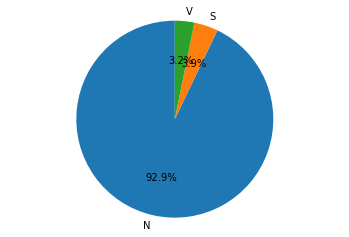

In [9]:
ids_n = balanced_df.index[balanced_df['stringLabel'] == 'N'].tolist() 
ids_v = balanced_df.index[balanced_df['stringLabel'] == 'V'].tolist() 
ids_s = balanced_df.index[balanced_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

In [10]:
from sklearn.model_selection import train_test_split

# Training set

train_df, validation_df = train_test_split(balanced_df, test_size=validation_percentage)


x_train_ = train_df[['first_lead','second_lead']].values

x_train = list()
for k in x_train_:
    x_train.append(np.asarray(k[0]+k[1]).astype(np.float32))
x_train = np.asarray(x_train).astype(np.float32)

y_train = train_df['label'].values.tolist()
y_train = np.asarray(y_train).astype(np.float32)

# Validation set

x_valid_ = validation_df[['first_lead','second_lead']].values

x_valid = list()
for k in x_valid_:
    x_valid.append(np.asarray(k[0]+k[1]).astype(np.float32))
x_valid = np.asarray(x_valid).astype(np.float32)

y_valid = validation_df['label'].values.tolist()
y_valid = np.asarray(y_valid).astype(np.float32)

print(f"samples available for training: {len(x_train)}")
print(f"samples available for validation: {len(x_valid)}")

samples available for training: 195468
samples available for validation: 48868


N: 181545
V: 6253
S: 7670


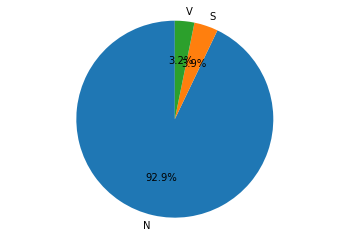

In [13]:
# count classes for training

ids_n = train_df.index[train_df['stringLabel'] == 'N'].tolist() 
ids_v = train_df.index[train_df['stringLabel'] == 'V'].tolist() 
ids_s = train_df.index[train_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

N: 45387
V: 1542
S: 1939


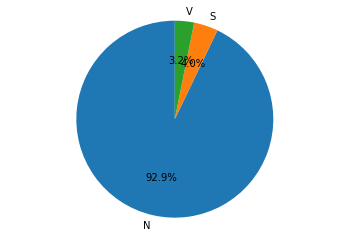

In [14]:
# count classes for validation

ids_n = validation_df.index[validation_df['stringLabel'] == 'N'].tolist() 
ids_v = validation_df.index[validation_df['stringLabel'] == 'V'].tolist() 
ids_s = validation_df.index[validation_df['stringLabel'] == 'S'].tolist() 

print(f"N: {len(ids_n)}")
print(f"V: {len(ids_v)}")
print(f"S: {len(ids_s)}")

classes = ["N","S","V"]
counts = [len(ids_n),len(ids_s),len(ids_v)]

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=None, labels=classes, autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
fig1.set_facecolor("white")
plt.show()

In [15]:
def plot_confusion_matrix(y_true, y_pred):
  """
    :param ndarray y_true: contains the ground truth labels in the shape (n_samples,)
    :param ndarray y_pred: contains the predicted labels in the shape (n_samples,)
  """
  con_mat = tf.math.confusion_matrix(labels=y_val_classes, predictions=y_pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  con_mat_df = pd.DataFrame(con_mat_norm,
                  index = classes, 
                  columns = classes)
  figure = plt.figure(figsize=(8, 8))
  sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Model

In [16]:
timesteps = length
channels_num = 2

vec_train = np.zeros((x_train.shape[0], int(x_train.shape[1]/2), channels_num))
vec_train[:,:,0] = x_train[:,:timesteps]
vec_train[:,:,1] = x_train[:,timesteps:]

vec_valid = np.zeros((x_valid.shape[0], int(x_valid.shape[1]/2), channels_num))
vec_valid[:,:,0] = x_valid[:,:timesteps]
vec_valid[:,:,1] = x_valid[:,timesteps:]

In [17]:
input = keras.layers.Input(shape=(timesteps, channels_num))

conv1 = keras.layers.Conv1D(filters=32,kernel_size=25,activation="relu")(input)
maxPool1 = keras.layers.MaxPool1D(pool_size=2)(conv1)
dropout1 = keras.layers.Dropout(0.05)(maxPool1)
conv2 = keras.layers.Conv1D(filters=64,kernel_size=12,activation="relu")(dropout1)
maxPool2 = keras.layers.MaxPool1D(pool_size=2)(conv2)
dropout2 = keras.layers.Dropout(0.1)(maxPool2)
conv3 = keras.layers.Conv1D(filters=128,kernel_size=9,activation="relu")(dropout2)
maxPool3 = keras.layers.MaxPool1D(pool_size=2)(conv3)
dropout3 = keras.layers.Dropout(0.15)(maxPool3)
lstm1 = keras.layers.LSTM(64, return_sequences=True)(dropout3)
lstm2 = keras.layers.LSTM(64, return_sequences=False)(lstm1)
output = keras.layers.Dense(3, activation=tf.nn.softmax)(lstm2)
model4 = keras.models.Model(inputs=input, outputs=output)

model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 510, 2)]          0         
                                                                 
 conv1d (Conv1D)             (None, 486, 32)           1632      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 243, 32)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 243, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 232, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 116, 64)          0         
 1D)                                                         

In [18]:
import keras.backend as K

def compute_class_freqs(labels):

    N = labels.shape[0]
    
    positive_frequencies = np.sum(labels, axis = 0) / N
    negative_frequencies = 1 - positive_frequencies

    return positive_frequencies, negative_frequencies

def compute_weighted_loss_params(y_train):
    freq_pos, freq_neg = compute_class_freqs(y_train)
    print(f"pos freqs: {freq_pos}")

    print(f"neg freqs: {freq_neg}")

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    plot_occ = pd.DataFrame({"Class": classes, "Label": "Positive", "Value": freq_pos})
    plot_occ = plot_occ.append([{"Class": classes[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)], ignore_index=True)
    plt.xticks(rotation=90)
    f = sns.barplot(ax = axes[0], x="Class", y="Value", hue="Label" ,data=plot_occ)
    pos_weights = freq_neg
    neg_weights = freq_pos
    pos_contribution = freq_pos * pos_weights 
    neg_contribution = freq_neg * neg_weights
    plot_occ = pd.DataFrame({"Class": classes, "Label": "Positive", "Value": pos_contribution})
    plot_occ = plot_occ.append([{"Class": classes[l], "Label": "Negative", "Value": v} 
                            for l,v in enumerate(neg_contribution)], ignore_index=True)
    plt.xticks(rotation=90)
    sns.barplot(ax = axes[1], x="Class", y="Value", hue="Label" ,data=plot_occ)
    return pos_weights, neg_weights


def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    def weighted_loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        # initialize loss to zero
        loss = 0.0
        
        for i in range(len(pos_weights)):
            loss += K.mean(-(pos_weights[i] *y_true[:,i] * K.log(y_pred[:,i] + epsilon) 
                             + neg_weights[i]* (1 - y_true[:,i]) * K.log( 1 - y_pred[:,i] + epsilon)))
        return loss    
    return weighted_loss

pos freqs: [0.92877095 0.03923916 0.03198989]
neg freqs: [0.07122905 0.96076084 0.96801011]
Epoch 1/50
3054/3054 [==============================] - 555s 177ms/step - loss: 0.0786 - accuracy: 0.8967 - val_loss: 0.0499 - val_accuracy: 0.9458
Epoch 2/50
3054/3054 [==============================] - 123s 40ms/step - loss: 0.0478 - accuracy: 0.9391 - val_loss: 0.0366 - val_accuracy: 0.9595
Epoch 3/50
3054/3054 [==============================] - 123s 40ms/step - loss: 0.0389 - accuracy: 0.9530 - val_loss: 0.0359 - val_accuracy: 0.9609
Epoch 4/50
3054/3054 [==============================] - 121s 40ms/step - loss: 0.0339 - accuracy: 0.9560 - val_loss: 0.0311 - val_accuracy: 0.9622
Epoch 5/50
3054/3054 [==============================] - 122s 40ms/step - loss: 0.0304 - accuracy: 0.9619 - val_loss: 0.0276 - val_accuracy: 0.9660
Epoch 6/50
3054/3054 [==============================] - 122s 40ms/step - loss: 0.0282 - accuracy: 0.9637 - val_loss: 0.0311 - val_accuracy: 0.9725
Epoch 7/50
3054/3054 [===

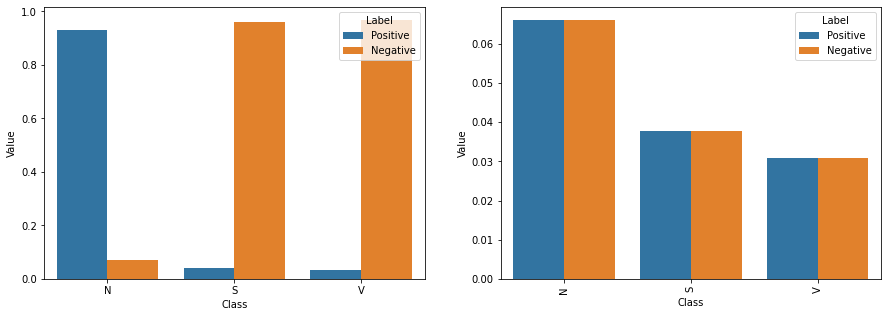

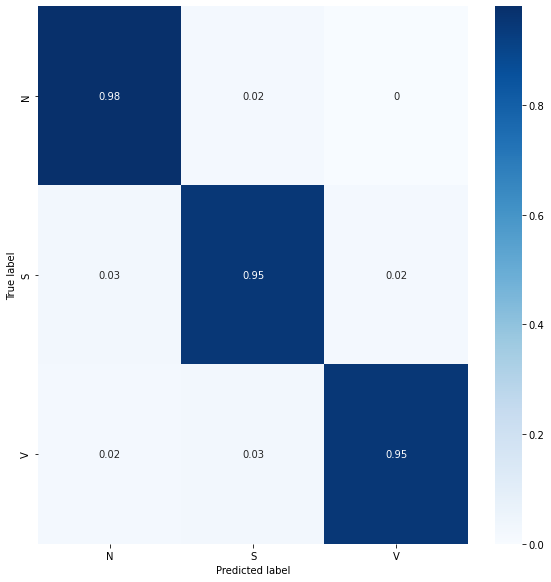

In [19]:
nn = model4

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,mode="auto")

pos_weights, neg_weights = compute_weighted_loss_params(y_train)

batch_size = 64
learning_rate = 0.00001
nn.compile(
    optimizer = 'adam',
    loss = get_weighted_loss(pos_weights, neg_weights),
    metrics = ['accuracy'],
    
)

history = nn.fit(
    x = vec_train,
    y = y_train, 
    batch_size = batch_size,
    steps_per_epoch=len(vec_train)/batch_size,
    validation_data=(vec_valid, y_valid),
    epochs = 50,
    shuffle = True,
    callbacks=[callback],
).history


y_pred= nn.predict(vec_valid)
y_pred=np.argmax(y_pred,axis=1)
y_val_classes=np.argmax(y_valid, axis=1)

plot_confusion_matrix(y_val_classes, y_pred)

In [20]:
eval = nn.evaluate(x=vec_valid,y=y_valid,batch_size = 1)

48868/48868 [==============================] - 490s 10ms/step - loss: 0.0229 - accuracy: 0.9803


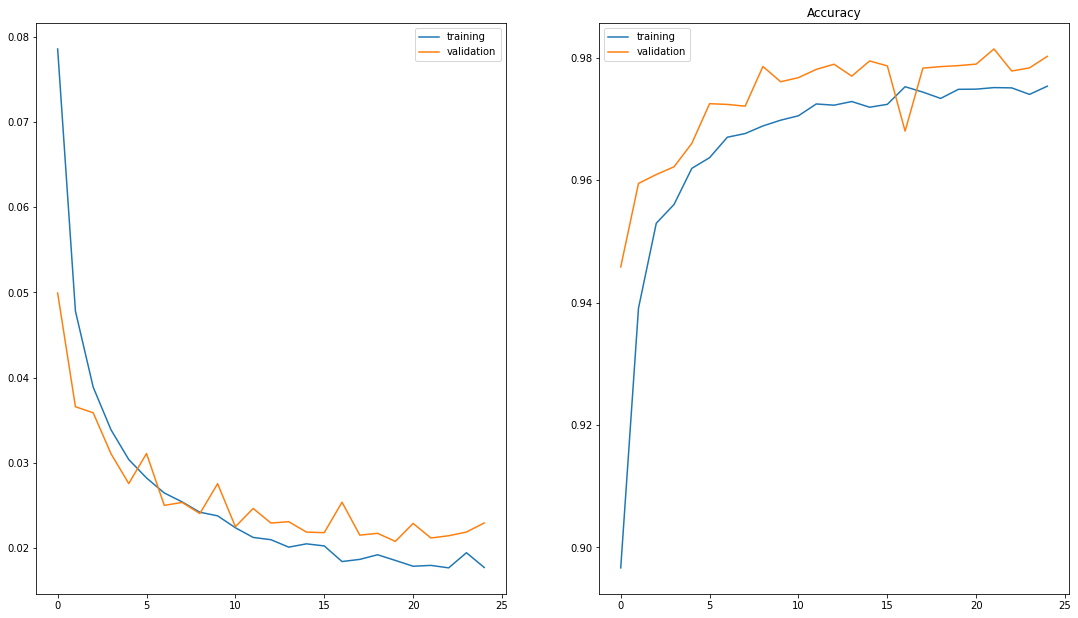

In [21]:
fig,(ax1,ax2) = plt.subplots(1,2)

x = range(len(history['loss']))
# loss
y_train = history['loss']
y_valid = history['val_loss']
ax2.set_title("Loss")
ax1.plot(x,y_train,label="training")
ax1.plot(x,y_valid,label="validation")
ax1.legend()
# accuracy 
y_train = history['accuracy']
y_valid = history['val_accuracy']
ax2.set_title("Accuracy")
ax2.plot(x,y_train,label="training")
ax2.plot(x,y_valid,label="validation")
ax2.legend()

fig.set_size_inches(18.5, 10.5)
plt.show()

Maybe we can train for more epochs increasing the batch size or reducing the learning rate to smooth validaton curves